In [60]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
from scipy.stats import qmc

In [61]:
S_nt_idx = lambda x: 17 * x
S_wt_idx = lambda x: 17 * x + 1
S_tp_idx = lambda x: 17 * x + 2
S_tn_idx = lambda x: 17 * x + 3
V_nt_idx = lambda x: 17 * x + 4
V_wt_idx = lambda x: 17 * x + 5
V_tp_idx = lambda x: 17 * x + 6
V_tn_idx = lambda x: 17 * x + 7
I_nt_idx = lambda x: 17 * x + 8
I_wt_idx = lambda x: 17 * x + 9
I_tn_idx = lambda x: 17 * x + 10
Q_idx = lambda x: 17 * x + 11
R_nt_idx = lambda x: 17 * x + 12 
R_wt_idx = lambda x: 17 * x + 13
R_tp_idx = lambda x: 17 * x + 14
R_tn_idx = lambda x: 17 * x + 15
D_idx = lambda x: 17 * x + 16

In [62]:
def compute_group_metrics(V, num_groups):
    """
    Inputs: V (the initial population for every compartment), num_groups (the number of subpopulations)
    
    This function computes the total susceptible, vaccinated, infected, and recovered individuals in each subpopulation

    Returns: N_list (list of the total population of each subgroup), S_effective, V_effective, I_active, R_total (list of the total susceptible, 
    vaccinated, infected, and recovered populations for each subgroup repectively)
    """
    N_list = []
    S_effective = []
    V_effective = []
    I_active = []
    R_total = []

    for i in range(num_groups): 
        s_eff = V[S_nt_idx(i)] + V[S_wt_idx(i)] + V[S_tp_idx(i)] + V[S_tn_idx(i)]
        v_eff = V[V_nt_idx(i)] + V[V_wt_idx(i)] + V[V_tp_idx(i)] + V[V_tn_idx(i)]
        i_act = V[I_nt_idx(i)] + V[I_wt_idx(i)] + V[I_tn_idx(i)]
        r_tot = V[R_nt_idx(i)] + V[R_wt_idx(i)] + V[R_tn_idx(i)] + V[R_tp_idx(i)]
        q_val = V[Q_idx(i)]

        S_effective.append(s_eff)
        V_effective.append(v_eff)
        I_active.append(i_act)
        R_total.append(r_tot)

        N_list.append(s_eff + v_eff + i_act + q_val + r_tot)

    return N_list, S_effective, V_effective, I_active, R_total

In [63]:
def diff_eqs(input, t, parameters, num_groups): 
    """
    Inputs: input (the intial values for each compartment), parameters (parameters of the system), num_groups (the number of subpopulations)

    This function defines the system of differential equations

    Returns: Y (list of differential equations) 
    """
    beta_matrix = parameters['beta']
    epsilon_matrix = parameters['epsilon']
    gamma_array = parameters['gamma']
    chi_array = parameters['chi']
    nu = parameters['nu']
    mu_array = parameters['mu']
    tau_array = parameters['tau']
    rho = parameters['rho']
    fnr = parameters['fnr']
    fpr = parameters['fpr']
    alpha = parameters['alpha']

    V = input
    Y = np.zeros(num_groups * 17)
    N, S_effective_all, V_effective_all, I_active_all, R_total_all = compute_group_metrics(V, num_groups)

    for i in range(num_groups):
         
        S_eff_i = max(S_effective_all[i], 1e-8)
        V_eff_i = max(V_effective_all[i], 1e-8)
        I_act_i = max(I_active_all[i], 1e-8)
        R_tot_i = max(R_total_all[i], 1e-8)

        susceptible_infec = sum((I_active_all[j] + nu * V[Q_idx(j)]) * beta_matrix[i, j] / N[j] for j in range(num_groups))
        vaccinated_infec = sum((I_active_all[j] + nu * V[Q_idx(j)]) * epsilon_matrix[i, j] / N[j] for j in range(num_groups))

        Snt, Swt, Stp, Stn = S_nt_idx(i), S_wt_idx(i), S_tp_idx(i), S_tn_idx(i)
        Vnt, Vwt, Vtp, Vtn = V_nt_idx(i), V_wt_idx(i), V_tp_idx(i), V_tn_idx(i)
        Int, Iwt, Itn = I_nt_idx(i), I_wt_idx(i), I_tn_idx(i)
        Q = Q_idx(i)
        Rnt, Rwt, Rtp, Rtn = R_nt_idx(i), R_wt_idx(i), R_tp_idx(i), R_tn_idx(i)
        D = D_idx(i)

        # Susceptible
        Y[Snt] = -susceptible_infec * V[Snt] - chi_array[i] * V[Snt] / S_eff_i - tau_array[i] * V[Snt] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) + alpha * (V[Stp] + V[Stn])
        Y[Swt] = -susceptible_infec * V[Swt] - chi_array[i] * V[Swt] / S_eff_i + tau_array[i] * V[Snt] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) - rho * V[Swt]
        Y[Stp] = -susceptible_infec * V[Stp] - chi_array[i] * V[Stp] / S_eff_i + rho * fpr * V[Swt] - alpha * V[Stp]
        Y[Stn] = -susceptible_infec * V[Stn] - chi_array[i] * V[Stn] / S_eff_i + rho * (1 - fpr) * V[Swt] - alpha * V[Stn]

        # Vaccinated
        Y[Vnt] = -vaccinated_infec * V[Vnt] + chi_array[i] * (V[Snt] / S_eff_i) + chi_array[i] * (V[Swt] / S_eff_i) + chi_array[i] * (V[Stn] / S_eff_i) + chi_array[i] * (V[Stp] / S_eff_i) - tau_array[i] * V[Vnt] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) + alpha * (V[Vtp] + V[Vtn])
        Y[Vwt] = -vaccinated_infec * V[Vwt] + tau_array[i] * V[Vnt] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) - rho * V[Vwt]
        Y[Vtp] = -vaccinated_infec * V[Vtp] + rho * fpr * V[Vwt] - alpha * V[Vtp]
        Y[Vtn] = -vaccinated_infec * V[Vtn] + rho * (1 - fpr) * V[Vwt] - alpha * V[Vtn]

        # Infected
        Y[Int] = susceptible_infec * S_eff_i + vaccinated_infec * V_eff_i - gamma_array[i] * V[Int] - mu_array[i] * V[Int] - tau_array[i] * V[Int] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) + alpha * (V[Itn] + V[Q])
        Y[Iwt] = tau_array[i] * V[Int] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) - rho * V[Iwt] - gamma_array[i] * V[Iwt] - mu_array[i] * V[Iwt]
        Y[Itn] = rho * fnr * V[Iwt] - gamma_array[i] * V[Itn] - mu_array[i] * V[Itn] - alpha * V[Itn]

        # Quarantined
        Y[Q] = rho * (1 - fnr) * V[Iwt] - gamma_array[i] * V[Q] - mu_array[i] * V[Q] - alpha * V[Q]

        # Recovered
        Y[Rnt] = gamma_array[i] * V[Int] + gamma_array[i] * V[Iwt] + gamma_array[i] * V[Itn] + gamma_array[i] * V[Q] - tau_array[i] * V[Rnt] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) + alpha * (V[Rtp] + V[Rtn])
        Y[Rwt] = tau_array[i] * V[Rnt] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) - rho * V[Rwt]
        Y[Rtp] = rho * fpr * V[Rwt] - alpha * V[Rtp]
        Y[Rtn] = rho * (1 - fpr) * V[Rwt] - alpha * V[Rtn]

        # Dead
        Y[D] = mu_array[i] * I_act_i + mu_array[i] * V[Q]


    return Y

In [85]:
#This defines the starting conditions for the system 
starting_infections = [0.01, 0.01] #Add this in
starting_vaccinations = [0.001, 0.001]
num_groups = len(starting_infections)
group_populations = [10**6, 10**6, 10**6]

INPUT_0 = []
for i in range(num_groups): 
    inf = starting_infections[i]
    vac = starting_vaccinations[i]
    sus = 1 - inf - vac
    pop = group_populations[i]

    group_state = [0] * 17 
    group_state[0] = sus 
    group_state[4] = vac
    group_state[8] = inf
    group_state_scaled = [val * pop for val in group_state]

    INPUT_0.extend(group_state_scaled)
INPUT_0 = np.array(INPUT_0)

R0 = 16
beta = R0*(0.0714)
epsilon = beta / 10

scenario_num = 2
scenario_list = [
    {
        'chi': [0, 0],
        'nu': 0.01,
        'tau': [90000, 0],
        'rho': 1,
        'fnr': 0.01,
        'fpr': 0.05,
        'alpha': 0.0714,
        'gamma': [0.0714 * (1 - 0.0653), 0.0714 * (1 - 0.0653)],
        'mu': [0.0714 * 0.0653, 0.0714 * 0.0653]
    },
    {
        'chi': [0, 0],
        'nu': 0.01,
        'tau': [90000, 0],
        'rho': 0.2,
        'fnr': 0.01,
        'fpr': 0.05,
        'alpha': 0.0714,
        'gamma': [0.0714 * (1 - 0.0653), 0.0714 * (1 - 0.0653)],
        'mu': [0.0714 * 0.0653, 0.0714 * 0.0653]
    },
    {
        'chi': [0, 80000],
        'nu': 0.01,
        'tau': [0, 0],
        'rho': 0.33,
        'fnr': 0.01,
        'fpr': 0.05,
        'alpha': 0.0714,
        'gamma': [0.0714 * (1 - 0.0653), 0.0714 * (1 - 0.0653)],
        'mu': [0.0714 * 0.0653, 0.0714 * 0.0653]
    },
    {
        'chi': [0, 0],
        'nu': 0.01,
        'tau': [0, 0],
        'rho': 0.33,
        'fnr': 0.01,
        'fpr': 0.05,
        'alpha': 0.0714,
        'gamma': [0.0714 * (1 - 0.0653), 0.0714 * (1 - 0.2)],
        'mu': [0.0714 * 0.0653, 0.0714 * 0.2]
    },
]

ND_end = 100 # Number of days to simulate
t_start = 0.0; t_end = ND_end; t_inc = 0.05
t_range_init = np.arange(t_start, t_end+t_inc, t_inc) # Time points to solve the system at

In [65]:
#This defines the min-max bounds of the parameters that are calibrated 
param_bounds = {}

for i in range(num_groups):
    for j in range(num_groups):
        param_bounds[f'beta_{i}{j}'] = (epsilon, num_groups * beta)           
        param_bounds[f'epsilon_{i}{j}'] = (0, epsilon)     

param_names = list(param_bounds.keys())

In [66]:
#Generate 1000 samples in [0, 1] for each parameter
n_samples = 1000
sampler = qmc.LatinHypercube(d=len(param_bounds))
lhs_samples = sampler.random(n=n_samples)

#Scale the samples to actual range
param_ranges = np.array([param_bounds[name] for name in param_names])
scaled_samples = qmc.scale(lhs_samples, param_ranges[:, 0], param_ranges[:, 1])

In [67]:
def enforce_within_group_dominance(matrix, margin): 
    """
    Inputs: matrix (beta or epsilon), margin to add to the diagonal entries
    
    This function ensures that the within-group transmission rate is higher that the between-group transmission rate by adding a margin to each 
    diagonal entry of the beta and epsilon transmission matrices
    """
    num_groups = matrix.shape[0]
    max_off_diag = max(
        matrix[i, j] for i in range(num_groups) for j in range(num_groups) if i != j
    )

    for i in range(num_groups):
        if matrix[i, i] <= max_off_diag:
            matrix[i, i] = max_off_diag + margin
    return matrix

In [68]:
def extract_model_outputs(RES_init, num_groups):
    """
    Inputs: RES_init (the solutions to the system of differential equations), num_groups (the number of subpopulations that we are modelling)

    This function returns the model predictions of infected, vaccinated, and dead individuals

    Returns: The model prediction for the number of infected, vaccinated, and dead individuals
    """
    num_timesteps = RES_init.shape[0]
    
    I_model = np.zeros((num_groups, num_timesteps))
    V_model = np.zeros((num_groups, num_timesteps))
    D_model = np.zeros((num_groups, num_timesteps))

    for i in range(num_groups):
        I_model[i, :] = (RES_init[:, I_nt_idx(i)] +
                         RES_init[:, I_wt_idx(i)] +
                         RES_init[:, I_tn_idx(i)])
        
        V_model[i, :] = (RES_init[:, V_nt_idx(i)] +
                         RES_init[:, V_wt_idx(i)] +
                         RES_init[:, V_tp_idx(i)] +
                         RES_init[:, V_tn_idx(i)])
        
        D_model[i, :] = RES_init[:, D_idx(i)]

    return I_model, V_model, D_model

In [69]:
def simulate_model(params, num_groups, scenario_list, scenario_num):
    """
    Inputs: params (the sampled parameter values), num_groups (the number of subgroups)

    This function simulates the disease spread system in order to calibrate the best set of parameters

    Returns: I_model, V_model, D_model (the model's predictions for the number of individuals in the respective compartments using the sampled parameters)
    """
    scenarios = scenario_list[scenario_num]
    param_dict = dict(zip(param_names, params))

    beta_matrix = np.zeros((num_groups, num_groups))
    epsilon_matrix = np.zeros((num_groups, num_groups))
    for i in range(num_groups):
        for j in range(num_groups):
            beta_matrix[i, j] = param_dict[f'beta_{i}{j}']
            epsilon_matrix[i, j] = param_dict[f'epsilon_{i}{j}']

    beta_matrix = enforce_within_group_dominance(beta_matrix, margin=0.8)
    epsilon_matrix = enforce_within_group_dominance(epsilon_matrix, margin=0.3)

    all_params = {
    'beta': beta_matrix,
    'epsilon': epsilon_matrix,
    'chi': scenarios['chi'],
    'nu': scenarios['nu'],
    'tau': scenarios['tau'],
    'rho': scenarios['rho'],
    'fnr': scenarios['fnr'],
    'fpr': scenarios['fpr'],
    'alpha': scenarios['alpha'],
    'gamma': scenarios['gamma'],
    'mu': scenarios['mu']
    }

    RES_init = spi.odeint(diff_eqs, INPUT_0, t_range_init, args=(all_params, num_groups))
    I_model, V_model, D_model = extract_model_outputs(RES_init, num_groups)
    return I_model, V_model, D_model

In [70]:
def MSE_func(params, I_data, V_data, D_data, num_groups, scenario_list, scenario_num): 
    """
    Inputs: params (the sampled parameters), I_data, V_data, D_data (the actual number of individuals in the respective compartments to compare the 
    model output to), num_groups (the number of subgroups)

    This functions computes the difference between the model prediction for susceptible, infected, and dead individuals and the actual data for the 
    respective compartments. The set of parameters that result in the lowest error will be chosen as the ideal set of parameters 

    Returns: the error
    """
    I_model, V_model, D_model = simulate_model(params, num_groups, scenario_list, scenario_num)
    T = I_data.shape[1]
    I_model = I_model[:, :T]
    V_model = V_model[:, :T]
    D_model = D_model[:, :T]
    return np.mean((I_model - I_data) ** 2) + np.mean((V_model - V_data) ** 2) + np.mean((D_model - D_data) ** 2)

In [71]:
#Calls the helper functions to simulate the best set of parameters resulting in the lowest error 
I_data = np.zeros((num_groups, ND_end))
V_data = np.zeros((num_groups, ND_end))
D_data = np.zeros((num_groups, ND_end))

for i in range(num_groups):
    I_start = (0.001 / (i + 1)) * 1e6
    I_end = (10000 / (i + 1))
    I_data[i] = np.linspace(I_start, I_end, ND_end) + np.random.normal(0, 10, ND_end)
    
    V_start = (0.0005 * (i + 1)) * 1e6
    V_end = (0.002 * (i + 1)) * 1e6
    V_data[i] = np.clip(np.linspace(V_start, V_end, ND_end) + np.random.normal(0, 100, ND_end), 0, None)
    
    D_start = (0.001 * (i + 1))
    D_end = (200 / (i + 1))
    D_data[i] = np.clip(np.linspace(D_start, D_end, ND_end) + np.random.normal(0, 5, ND_end), 0, None)

best_params = None
lowest_error = np.inf
for sample in scaled_samples: 
    error = MSE_func(sample, I_data, V_data, D_data, num_groups, scenario_list, scenario_num)
    if error < lowest_error: 
        lowest_error = error
        best_params = sample 
print("Best parameter set:", dict(zip(param_names, best_params)))

Best parameter set: {'beta_00': 0.5789684461698348, 'epsilon_00': 0.11183648695647036, 'beta_01': 0.3938000535384574, 'epsilon_01': 0.02754278162191842, 'beta_10': 0.5149525961128825, 'epsilon_10': 0.04232521540098451, 'beta_11': 0.6806232633232007, 'epsilon_11': 0.03312314464753419}


In [72]:
def unpack_params(best_params, num_groups):
    """
    Inputs: best_params (dictionary containing the set of fitted parameters that result in the lowest error), num_groups (the number of subgroups)

    This function takes the dictionary best_params and unpacks them into scalar values that can be used when solving the final system of equations

    Returns: all of the parameters estimated using latin hypercube sampling
    """
    beta = np.array([
        best_params[f'beta_{i}{j}']
        for i in range(num_groups)
        for j in range(num_groups)
    ]).reshape((num_groups, num_groups))

    epsilon = np.array([
        best_params[f'epsilon_{i}{j}']
        for i in range(num_groups)
        for j in range(num_groups)
    ]).reshape((num_groups, num_groups))
    
    return beta, epsilon

In [73]:
def run_model(param_names, best_params, scenarios, num_groups, INPUT_0, t_range_init, scenario_num):
    best_params_dict = dict(zip(param_names, best_params))
    beta, epsilon = unpack_params(best_params_dict, num_groups)

    all_params = {
        'beta': beta,
        'epsilon': epsilon,
        'chi': scenarios['chi'],
        'nu': scenarios['nu'],
        'tau': scenarios['tau'],
        'rho': scenarios['rho'],
        'fnr': scenarios['fnr'],
        'fpr': scenarios['fpr'],
        'alpha': scenarios['alpha'],
        'gamma': scenarios['gamma'],
        'mu': scenarios['mu']
    }

    RES_init = spi.odeint(diff_eqs, INPUT_0, t_range_init, args=(all_params, num_groups))
    return RES_init



 Scenario 1 – Group 1:
  Final Susceptible: 19
  Final Infected: 518 (peak: 632,706)
  Final Vaccinated: 248
  Final Quarantined: 624 (peak: 227,067)
  Final Recovered: 933,383
  Final Dead: 65,208
  Total Population: 1,000,000

 Scenario 1 – Group 2:
  Final Susceptible: 1
  Final Infected: 1,101 (peak: 758,785)
  Final Vaccinated: 425
  Final Quarantined: 0 (peak: 0)
  Final Recovered: 933,273
  Final Dead: 65,200
  Total Population: 1,000,000


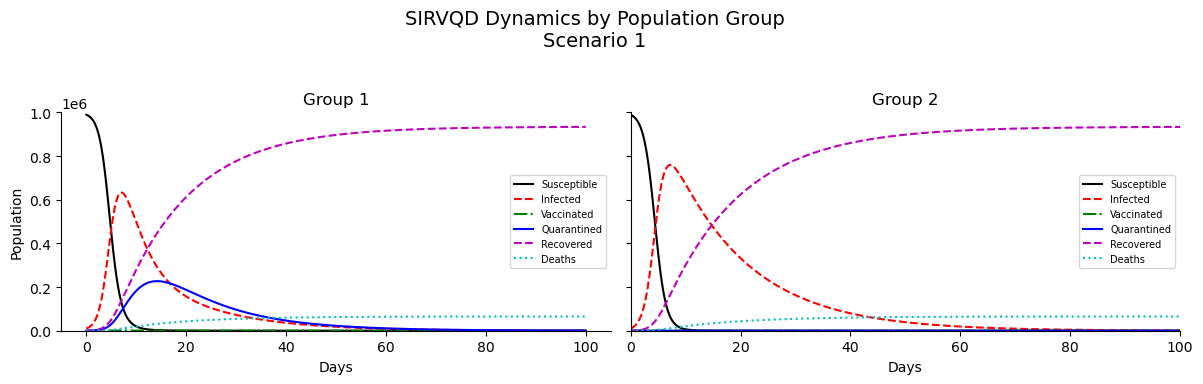


 Scenario 2 – Group 1:
  Final Susceptible: 8
  Final Infected: 598 (peak: 697,712)
  Final Vaccinated: 207
  Final Quarantined: 535 (peak: 146,653)
  Final Recovered: 933,441
  Final Dead: 65,212
  Total Population: 1,000,000

 Scenario 2 – Group 2:
  Final Susceptible: 0
  Final Infected: 1,097 (peak: 762,556)
  Final Vaccinated: 397
  Final Quarantined: 0 (peak: 0)
  Final Recovered: 933,304
  Final Dead: 65,202
  Total Population: 1,000,000


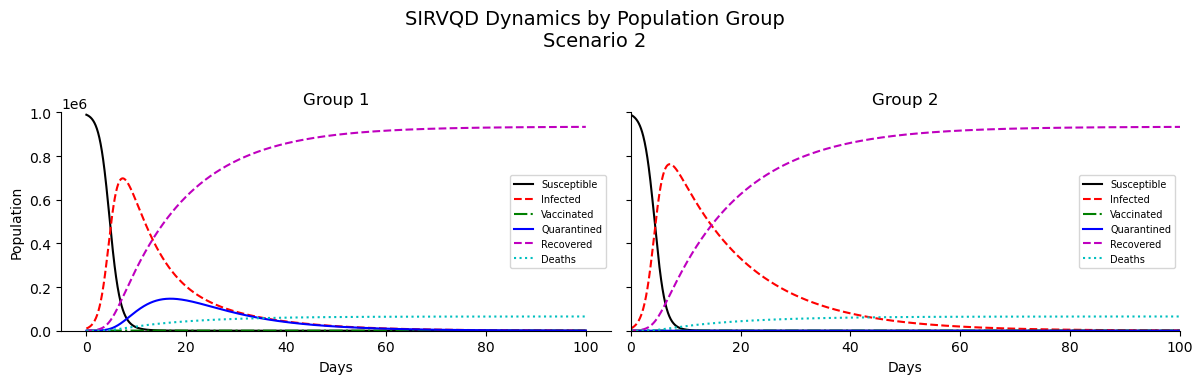


 Scenario 3 – Group 1:
  Final Susceptible: 3
  Final Infected: 1,170 (peak: 711,921)
  Final Vaccinated: 145
  Final Quarantined: 0 (peak: 0)
  Final Recovered: 933,469
  Final Dead: 65,214
  Total Population: 1,000,000

 Scenario 3 – Group 2:
  Final Susceptible: -0
  Final Infected: 2,934 (peak: 417,613)
  Final Vaccinated: 203,504
  Final Quarantined: 0 (peak: 0)
  Final Recovered: 741,742
  Final Dead: 51,820
  Total Population: 1,000,000


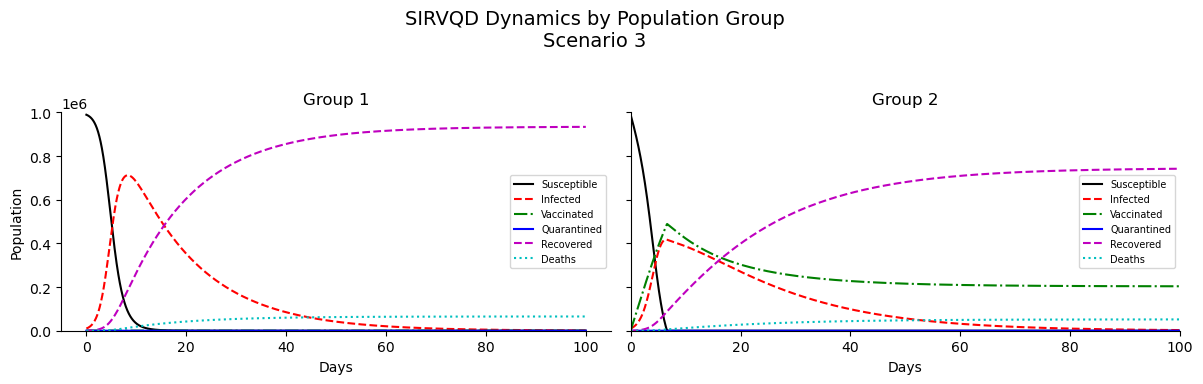


 Scenario 4 – Group 1:
  Final Susceptible: 0
  Final Infected: 1,128 (peak: 745,311)
  Final Vaccinated: 129
  Final Quarantined: 0 (peak: 0)
  Final Recovered: 933,525
  Final Dead: 65,218
  Total Population: 1,000,000

 Scenario 4 – Group 2:
  Final Susceptible: 0
  Final Infected: 1,094 (peak: 765,753)
  Final Vaccinated: 323
  Final Quarantined: 0 (peak: 0)
  Final Recovered: 798,866
  Final Dead: 199,716
  Total Population: 1,000,000


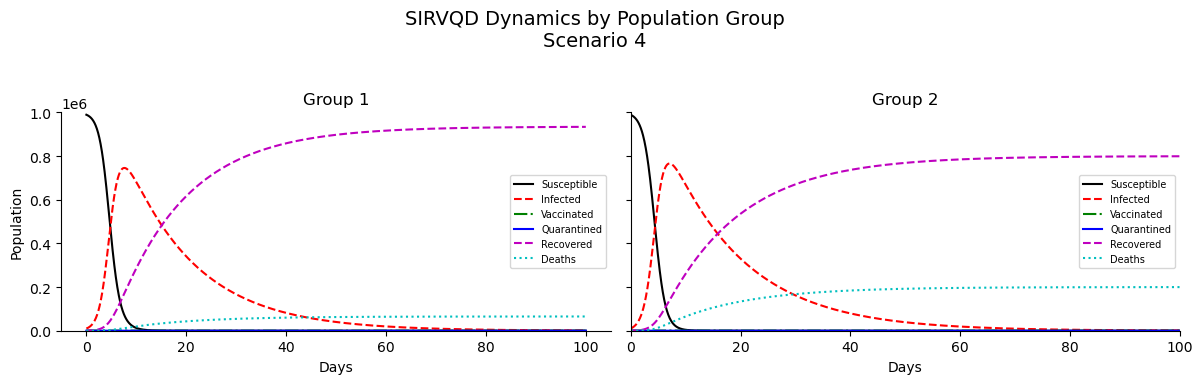

In [87]:
for idx, scenario in enumerate(scenario_list):

    INPUT_0 = []
    for i in range(num_groups): 
        inf = starting_infections[i]
        vac = starting_vaccinations[i]
        sus = 1 - inf - vac
        pop = group_populations[i]

        group_state = [0] * 17 
        group_state[0] = sus 
        group_state[4] = vac
        group_state[8] = inf
        group_state_scaled = [val * pop for val in group_state]

        INPUT_0.extend(group_state_scaled)
    INPUT_0 = np.array(INPUT_0)


    RES_init = run_model(param_names, best_params, scenario, num_groups, INPUT_0, t_range_init, idx)

    compartments_per_group = 17  
    t_vals = np.arange(0, ND_end + t_inc, t_inc)

    fig, axs = plt.subplots(1, num_groups, figsize=(6*num_groups, 4), sharey=True)

    if num_groups == 1:
        axs = [axs]  # make iterable

    for i in range(num_groups):
        offset = compartments_per_group * i
        S_total = RES_init[:, offset + 0] + RES_init[:, offset + 1] + RES_init[:, offset + 2] + RES_init[:, offset + 3]
        I_total = RES_init[:, offset + 8] + RES_init[:, offset + 9] + RES_init[:, offset + 10]
        V_total = RES_init[:, offset + 4] + RES_init[:, offset + 5] + RES_init[:, offset + 6] + RES_init[:, offset + 7]
        Q = RES_init[:, offset + 11]
        R = RES_init[:, offset + 12] + RES_init[:, offset + 13] + RES_init[:, offset + 14] + RES_init[:, offset + 15]
        D = RES_init[:, offset + 16]

        print(f"\n Scenario {idx+1} – Group {i+1}:")
        print(f"  Final Susceptible: {S_total[-1]:,.0f}")
        print(f"  Final Infected: {I_total[-1]:,.0f} (peak: {np.max(I_total):,.0f})")
        print(f"  Final Vaccinated: {V_total[-1]:,.0f}")
        print(f"  Final Quarantined: {Q[-1]:,.0f} (peak: {np.max(Q):,.0f})")
        print(f"  Final Recovered: {R[-1]:,.0f}")
        print(f"  Final Dead: {D[-1]:,.0f}")
        print(f"  Total Population: {S_total[-1] + I_total[-1] + V_total[-1] + Q[-1] + R[-1] + D[-1]:,.0f}")

        axs[i].plot(t_vals, S_total, '-k', label='Susceptible')
        axs[i].plot(t_vals, I_total, '--r', label='Infected')
        axs[i].plot(t_vals, V_total, '-.g', label='Vaccinated')
        axs[i].plot(t_vals, Q, '-b', label='Quarantined')
        axs[i].plot(t_vals, R, '--m', label='Recovered')
        axs[i].plot(t_vals, D, ':c', label='Deaths')

        axs[i].set_title(f'Group {i+1}')
        axs[i].set_xlabel('Days')
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].legend(fontsize=7)
        # axs[i].set_ylim(0, max(np.max(S_total), np.max(I_total), np.max(V_total), np.max(Q), np.max(R), np.max(D)) * 1.1)

    axs[0].set_ylabel('Population')
    plt.suptitle(f"SIRVQD Dynamics by Population Group\nScenario {idx+1}", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.xlim([0, ND_end])
    plt.ylim([0, 10 ** 6])
    plt.savefig(f"SIRVQD_scenario_{idx+1}.png", bbox_inches="tight")
    plt.show()